In [31]:
!pip install datasets

In [71]:
pip install accelerate -U

^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install transformers[torch]

## Hemg/AI-Generated-vs-Real-Images-Datasets

In [61]:
from datasets import load_dataset

ds = load_dataset("Hemg/AI-Generated-vs-Real-Images-Datasets")

In [62]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 152710
    })
})

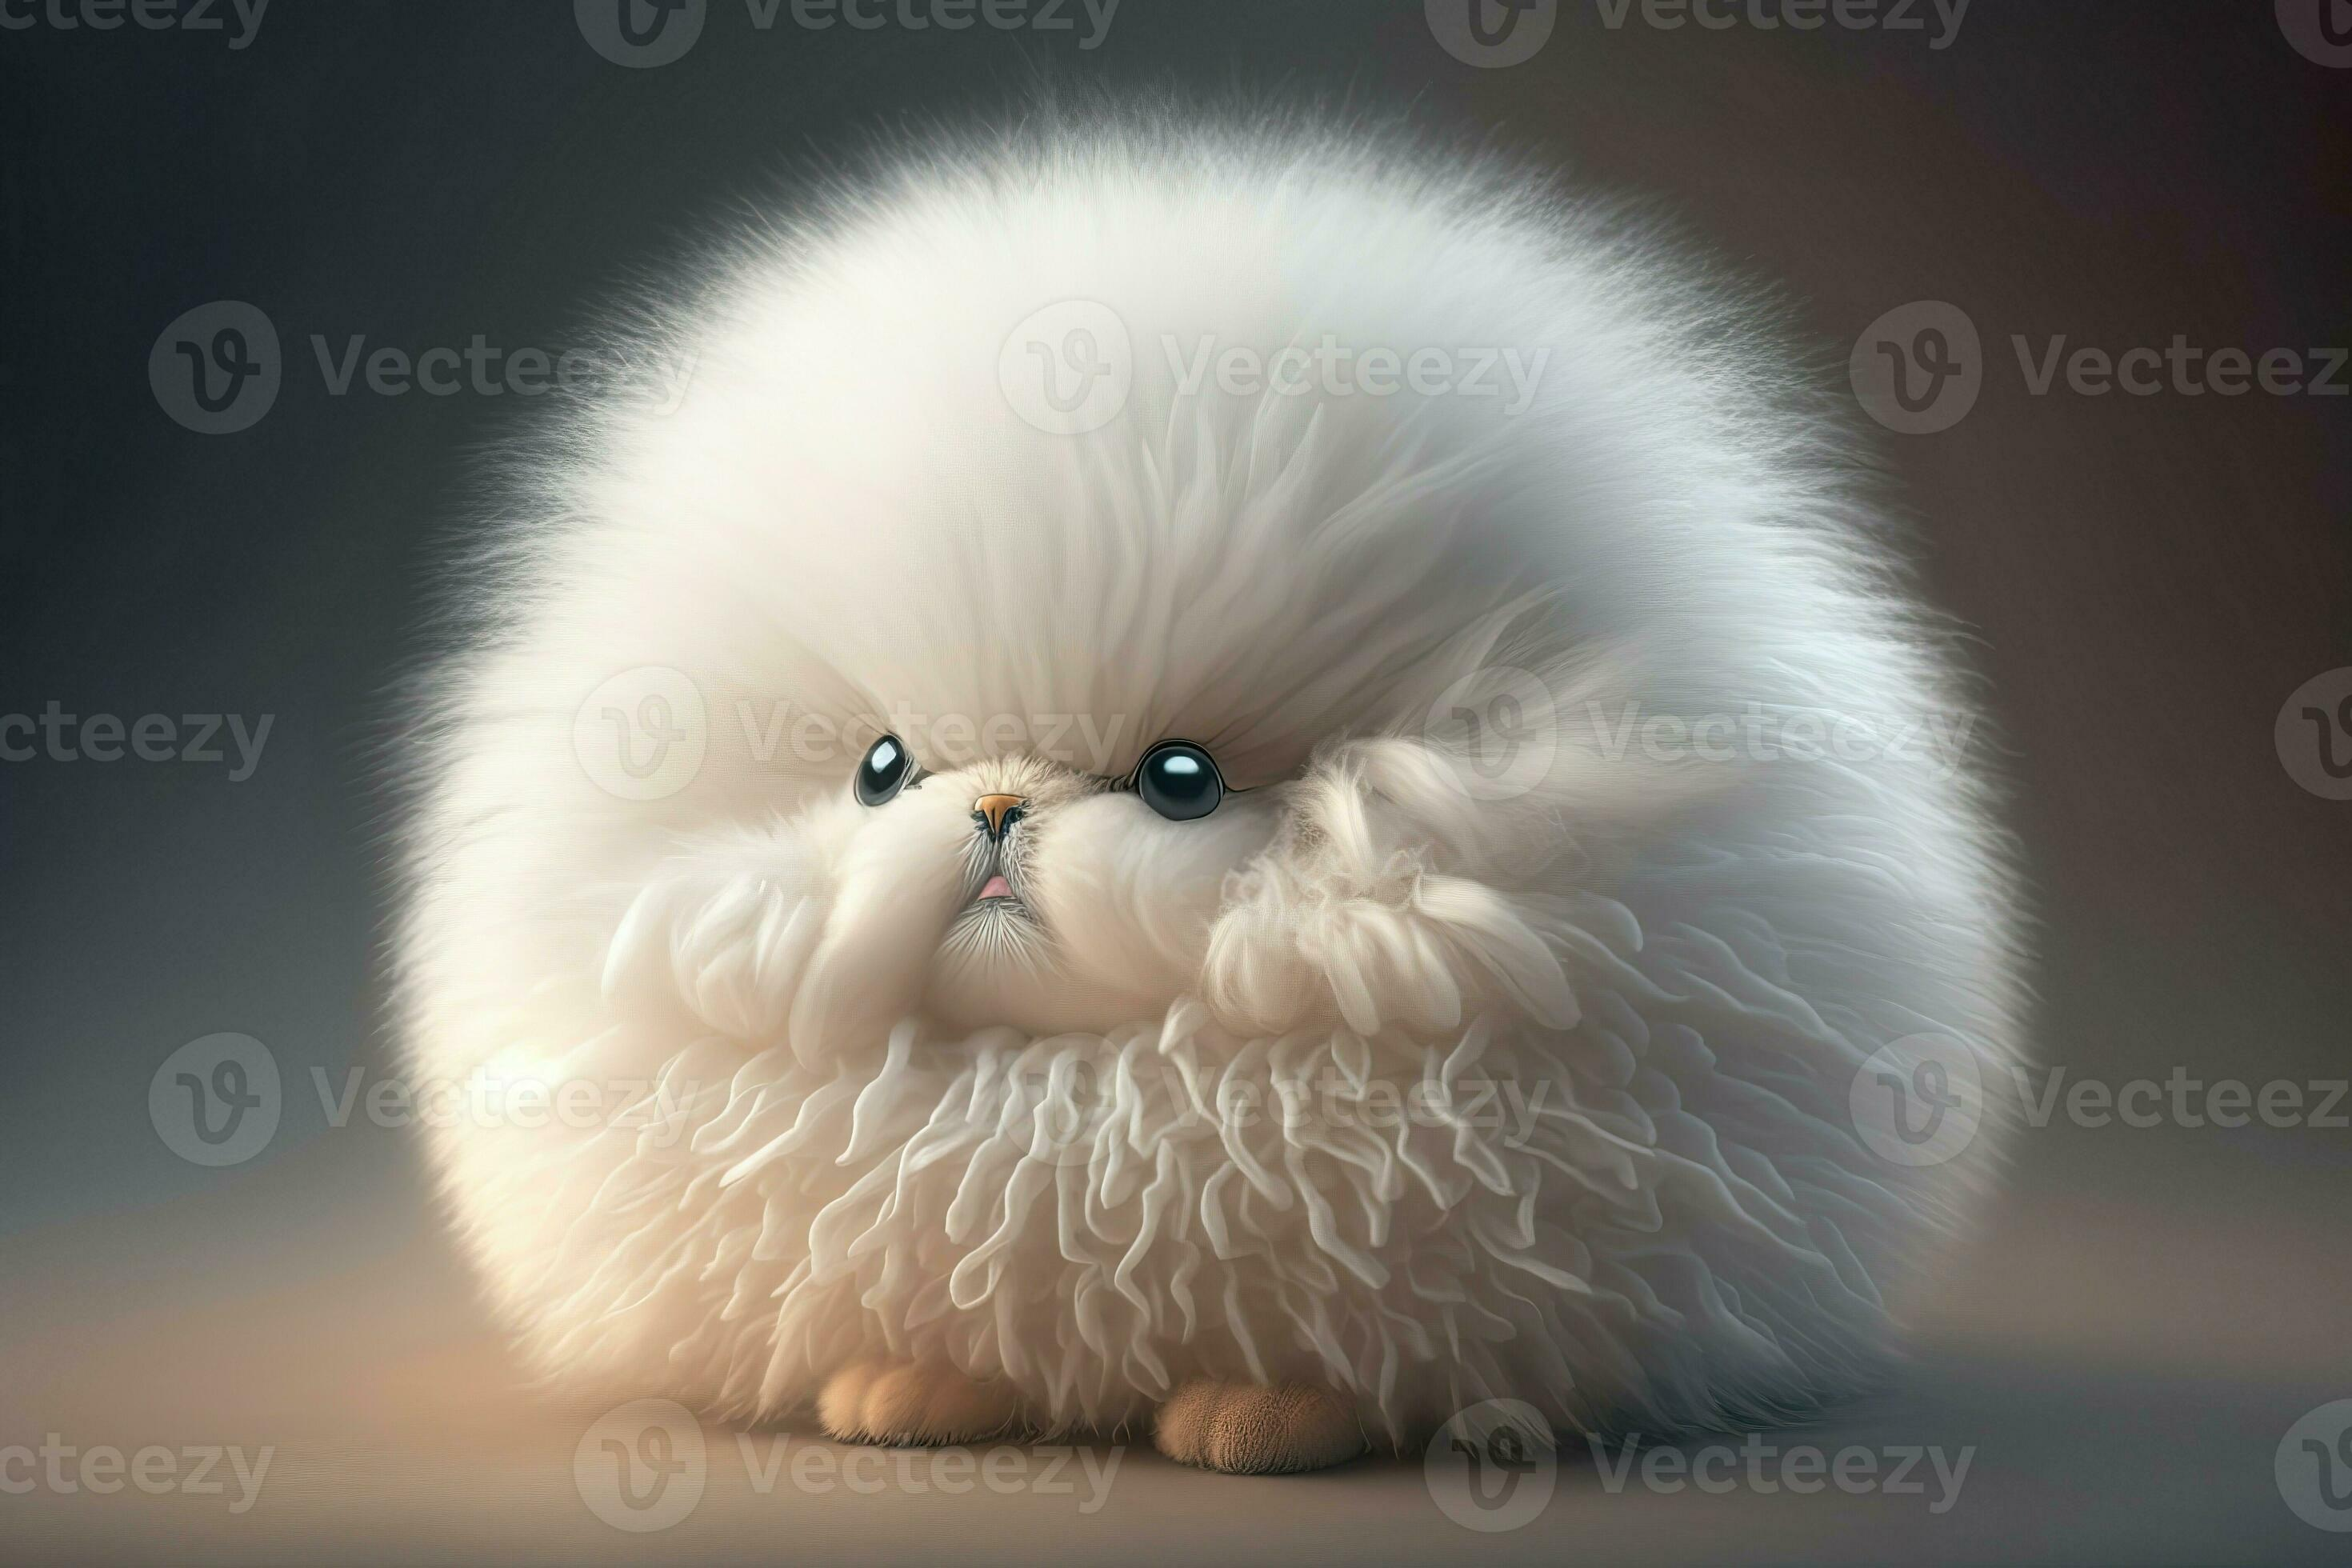

In [63]:
ds['train'][1]['image']

In [40]:
print(ds['train'][1]['label']) # Generated BY AI

0


In [42]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 152710
    })
})

### Transformer model

In [45]:
model_checkpoint = "microsoft/swin-tiny-patch4-window7-224" # pre-trained model from which to fine-tune
batch_size = 32 # batch size for training and evaluation

In [46]:
from huggingface_hub import notebook_login

notebook_login()

In [64]:
from transformers import AutoImageProcessor

image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


ViTImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [65]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [66]:
# split up training into training + validation
splits = ds["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [67]:
labels = ds["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[0]

'AiArtData'

In [68]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [69]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
 'label': 1,
 'pixel_values': tensor([[[ 1.6495,  1.7523,  1.7865,  ...,  0.9817,  0.9646,  0.8961],
          [ 1.6667,  1.7694,  1.8037,  ...,  0.9303,  0.9303,  0.8447],
          [ 1.7009,  1.8037,  1.8550,  ...,  0.8618,  0.8618,  0.7591],
          ...,
          [-0.9363, -0.9705, -1.0390,  ..., -1.0904, -1.0390, -1.0048],
          [-0.8678, -0.8849, -0.9534,  ..., -1.0733, -1.0562, -1.0219],
          [-0.8164, -0.8335, -0.8678,  ..., -1.0733, -1.0562, -1.0219]],
 
         [[ 0.8354,  0.9405,  0.9755,  ...,  0.4853,  0.4328,  0.2927],
          [ 0.8354,  0.9580,  0.9930,  ...,  0.4328,  0.3627,  0.2402],
          [ 0.8529,  0.9755,  1.0455,  ...,  0.3452,  0.2752,  0.1527],
          ...,
          [-1.2479, -1.2304, -1.2479,  ..., -1.2129, -1.2129, -1.2304],
          [-1.1604, -1.1604, -1.1604,  ..., -1.1779, -1.1954, -1.2304],
          [-1.0903, -1.1078, -1.0903,  ..., -1.1604, -1.1954, -1.2304]]

In [70]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [72]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-eurosat",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

In [73]:
from datasets import load_metric

metric = load_metric("accuracy")

/opt/conda/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [74]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [75]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [77]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [78]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ·····································


wandb: ERROR API key must be 40 characters long, yours was 37
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparenc

***** train metrics *****
  epoch                    =          10.0
  total_flos               = 31815676672GF
  train_loss               =        0.1579
  train_runtime            =    3:46:14.34
  train_samples_per_second =       101.249
  train_steps_per_second   =         0.396


In [79]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


***** eval metrics *****
  epoch                   =       10.0
  eval_accuracy           =     0.9765
  eval_loss               =     0.0675
  eval_runtime            = 0:01:17.53
  eval_samples_per_second =    196.967
  eval_steps_per_second   =      3.083


In [80]:
trainer.push_to_hub()

events.out.tfevents.1718964753.5518c494d663.34.1:   0%|          | 0.00/411 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/AZIIIIIIIIZ/swin-tiny-patch4-window7-224-finetuned-eurosat/commit/2dd0c66c901de0adae80470e43f4db2dfb2a8f00', commit_message='End of training', commit_description='', oid='2dd0c66c901de0adae80470e43f4db2dfb2a8f00', pr_url=None, pr_revision=None, pr_num=None)

### Inference

In [ ]:
# from PIL import Image
# import requests

# url = 'https://huggingface.co/AZIIIIIIIIZ/swin-tiny-patch4-window7-224-finetuned-eurosat/blob/main/image%20(1).jpg'


# image = Image.open(requests.get(url, stream=True).raw)
# image
#--------------------------------------------------------

# image_data = requests.get(url, stream=True).raw
# if isinstance(image_data, bytes):
#     image = Image.open(io.BytesIO(image_data))
# elif isinstance(image_data, dict):
#     image = Image.open(io.BytesIO(image_data['bytes']))
# else:
#     raise ValueError("Unsupported image format")



# This portion is part of my test code
# byteImg = Image.open(requests.get(url, stream=True).raw).tobytes()

# # Non test code
# dataBytesIO = io.BytesIO(byteImg)
# Image.open(dataBytesIO)

### Load

In [ ]:
# from transformers import AutoModelForImageClassification, AutoImageProcessor

# repo_name = "nielsr/swin-tiny-patch4-window7-224-finetuned-eurosat"

# image_processor = AutoImageProcessor.from_pretrained(repo_name)
# model = AutoModelForImageClassification.from_pretrained(repo_name)

In [ ]:
# # prepare image for the model
# encoding = image_processor(image.convert("RGB"), return_tensors="pt")
# print(encoding.pixel_values.shape)

In [ ]:
# import torch

# # forward pass
# with torch.no_grad():
#     outputs = model(**encoding)
#     logits = outputs.logits

In [ ]:
# predicted_class_idx = logits.argmax(-1).item()
# print("Predicted class:", model.config.id2label[predicted_class_idx])

### Pipeline API

In [ ]:
# from transformers import pipeline

# pipe = pipeline("image-classification", "nielsr/swin-tiny-patch4-window7-224-finetuned-eurosat")

In [ ]:
# pipe(image)

In [ ]:
# pipe = pipeline("image-classification",
#                 model=model,
#                 feature_extractor=image_processor)

In [ ]:
# pipe(image)